# Prueba 2: Analizado los crímenes en la Ciudad de Nueva York (Sebastián Rebolledo)

## Hito 1: Aspectos Computacionales

#### En el siguiente trabajo se realizará utilizando una base de datos de la policia de New York y contiene información sobre interrogaciones y detenciones realizadas por ellos. El objetivo es poder reportar la probabilidad de que un sea arrestado o no y predecir si alguna detención terminará en alguna accion violenta.

### Preliminares

- Las metricas que se utilizarán para medir el desempeño de los modelos serán Accuracy, precision y Recall. 
- Se realizará primeramente el analisis de datos perdidos en la base de datos.
- Luego se realizará un preprocesamiento en el vector arstmade .

### Modelos a implementar

- Regresion logistica.

- LinearDiscriminantAnalysis.

- Árbol de clasificación, en donde se implementara una grilla para buscar los mejores hiperparametros. A continuacion grilla tentativa.
    - params = {'max_depth':[30,70,150,200], }
    
- GradientBoostingClasifiers : Se implementara una grilla para buscar los mejores hiperparametros. A continuacion grilla tentativa.
    - params = {'learning_rate': [0.01, 0.1, 0.5],'n_estimators': [50, 100, 500, 1000, 2000], 'subsample': [0.1,0.5,0.9]}.
                   
- AdaBoostClassifier: Se implementara una grilla para buscar los mejores hiperparametros. A continuacion grilla tentativa.
     - params = {'learning_rate': [0.01, 0.1, 0.5], 'n_estimators': [50, 100, 500, 1000, 2000]}

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import func as fn
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msngo
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('2009_1perc.csv').drop('Unnamed: 0', axis=1)

### Analisis de datos perdidos

<AxesSubplot:>

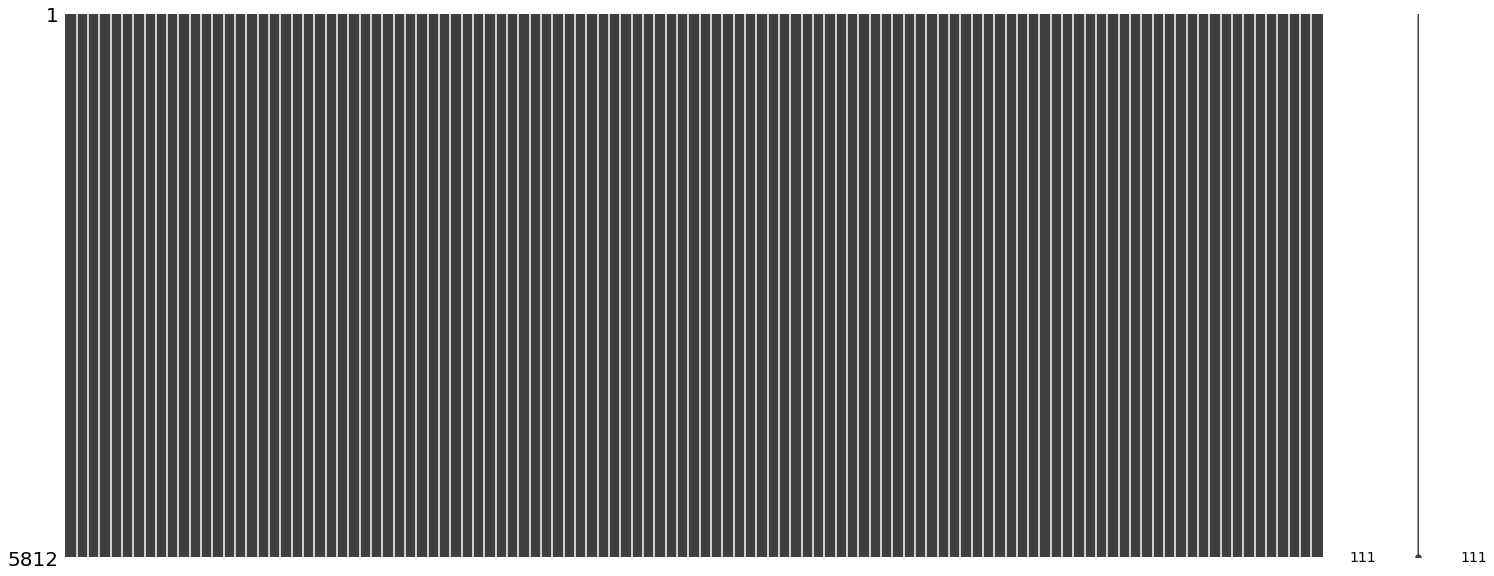

In [3]:
msngo.matrix(df)

In [4]:
df.zip.value_counts()

     5812
Name: zip, dtype: int64

El grafico superior nos indica que no hay valores perdidos, pero observando el dataset nos podemos dar cuenta de que hay columnas que estan en blanco, rellenadas por espacios (' '), lo que genera que el grafico de arriba nos entregue mal la información.
Se recodificarán los espacios (' ') por NaN y se repetirá la busqueda de datos perdidos.

In [5]:
def ver_datos_perdidos(df):
    for cols in df.columns:
        df[cols]=np.where(df[cols]==' ', np.nan, df[cols])
    return df

In [6]:
df = ver_datos_perdidos(df)

<AxesSubplot:>

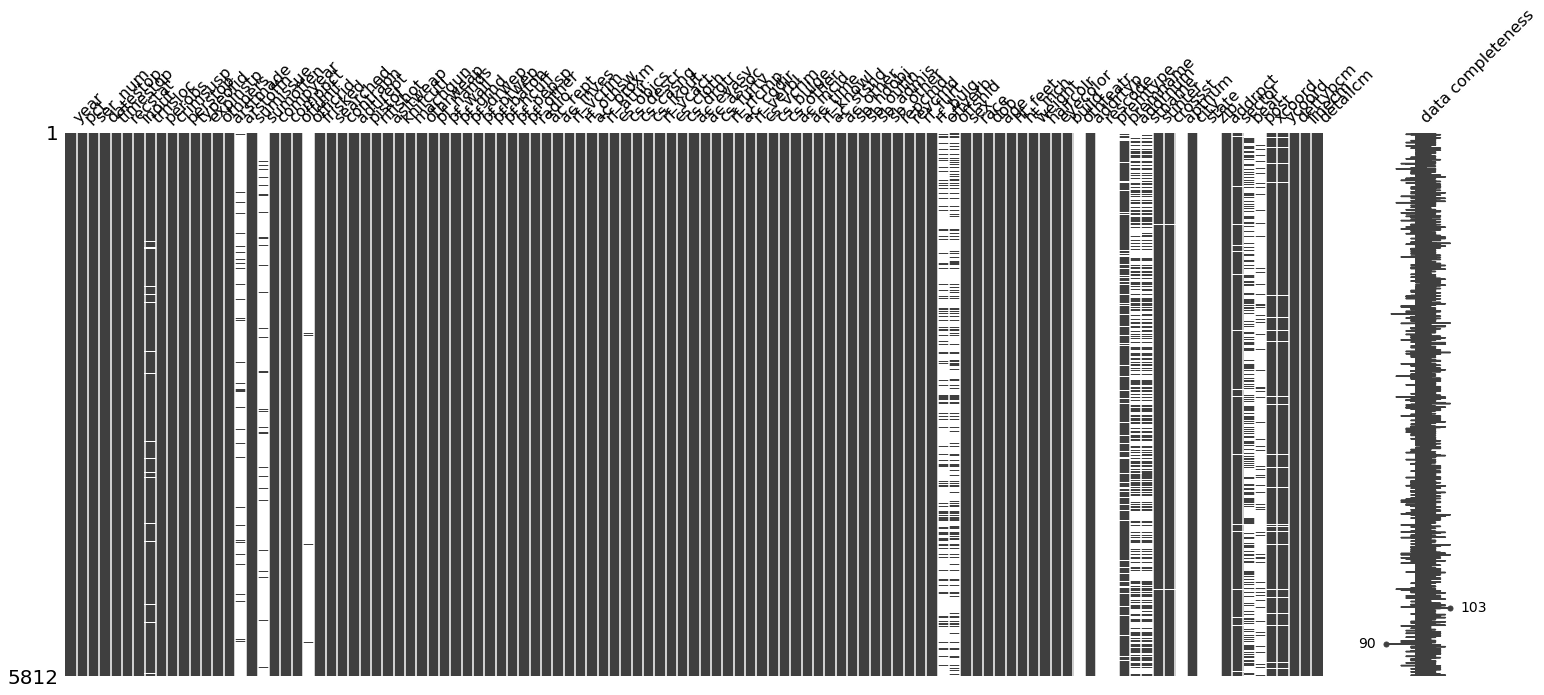

In [7]:
msngo.matrix(df, labels=True)

Se eliminarán las columnas no tienen valores

In [8]:
df=df.drop(['zip','state','city', 'crossst', 'premname','aptnum', 'rescode', 'build', 'premtype', 'othfeatr',
           'officrid', 'sumoffen','post','beat', 'comppct'], axis=1)

<AxesSubplot:>

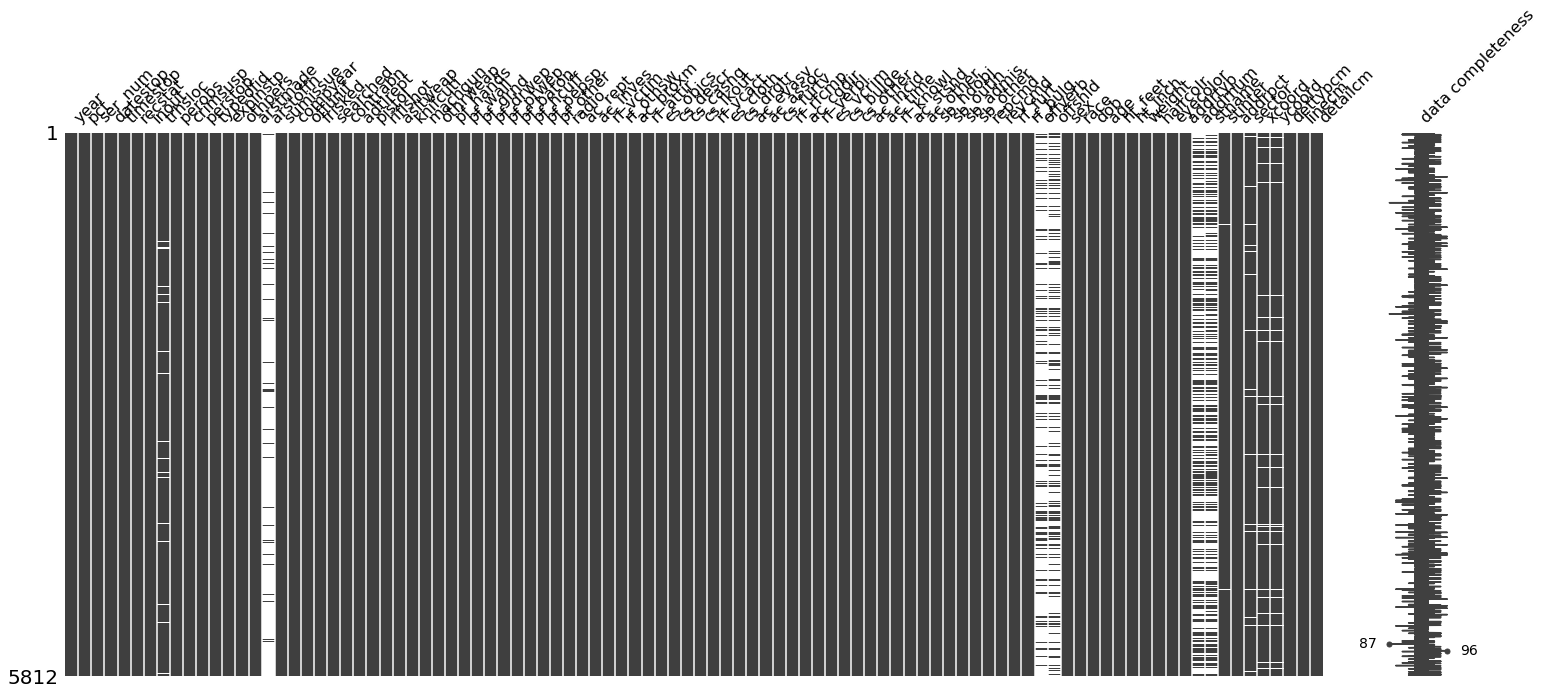

In [9]:
msngo.matrix(df, labels=True)

A continuación se eliminarán las columnas que no sirven para predecir si el procedimiento concluira en arresto, debido a que estas ocurren posterior a la detención y las que le indican al modelo cuando se genero un arresto.

In [10]:
df=df.drop(['offverb', 'offshld','addrnum', 'detailcm','frisked', 'searched', 'contrabn', 'adtlrept',
           'pistol', 'riflshot', 'asltweap', 'knifcuti', 'machgun', 'othrweap', 'offshld','arstoffn','compyear',
           'contrabn', 'year', 'linecm','addrtyp', 'crimsusp'], axis=1)

Se refactoriza la columna 'stname', quitando los valores perdidos y agregando la clase 'no registration'

In [11]:
df['stname'] = np.where(df['stname'].isna(), 'no registration', df['stname'])

In [12]:
df['xcoord'] = df['xcoord'].astype('float64')
df['ycoord'] = df['ycoord'].astype('float64')

<AxesSubplot:>

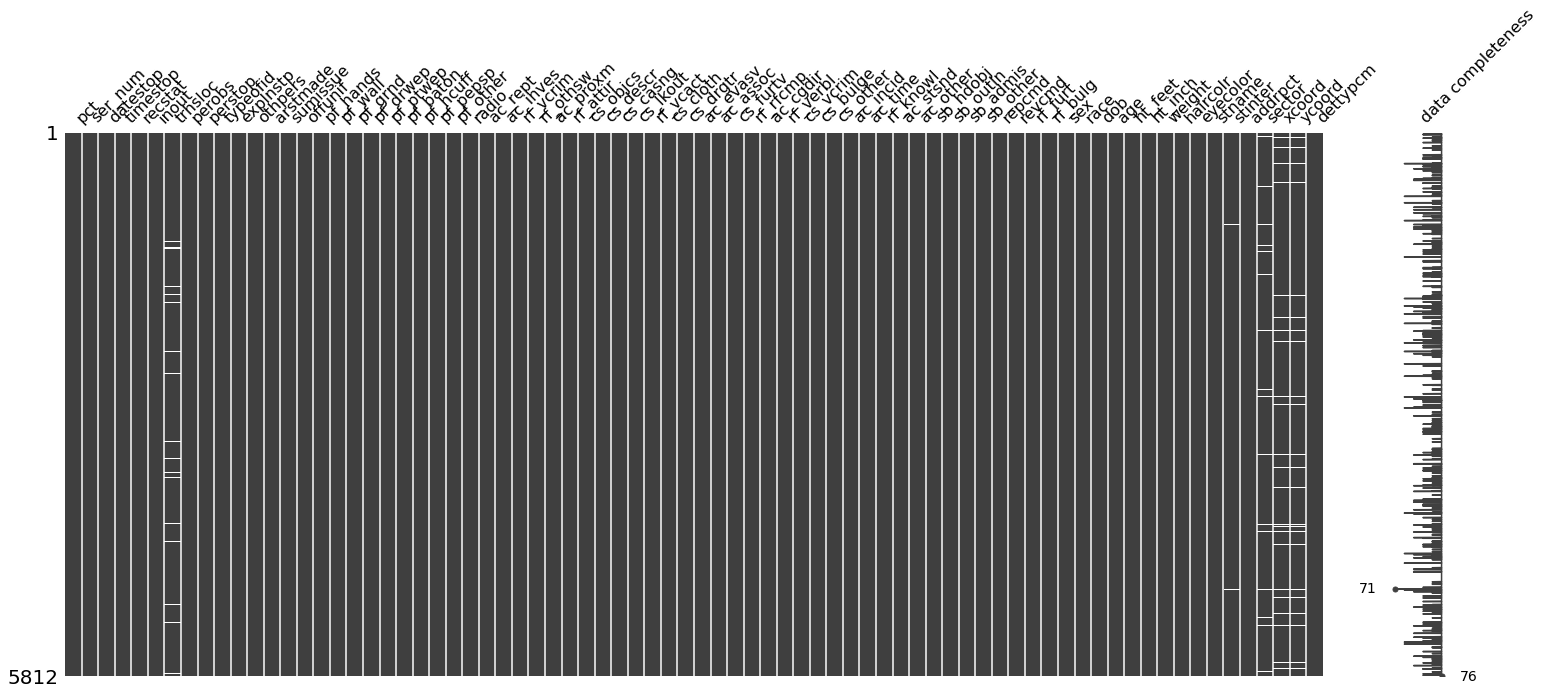

In [13]:
msngo.matrix(df, labels=True)

A continuacion se eliminarán las filas con datos perdidos.

In [14]:
df=df.dropna()

<AxesSubplot:>

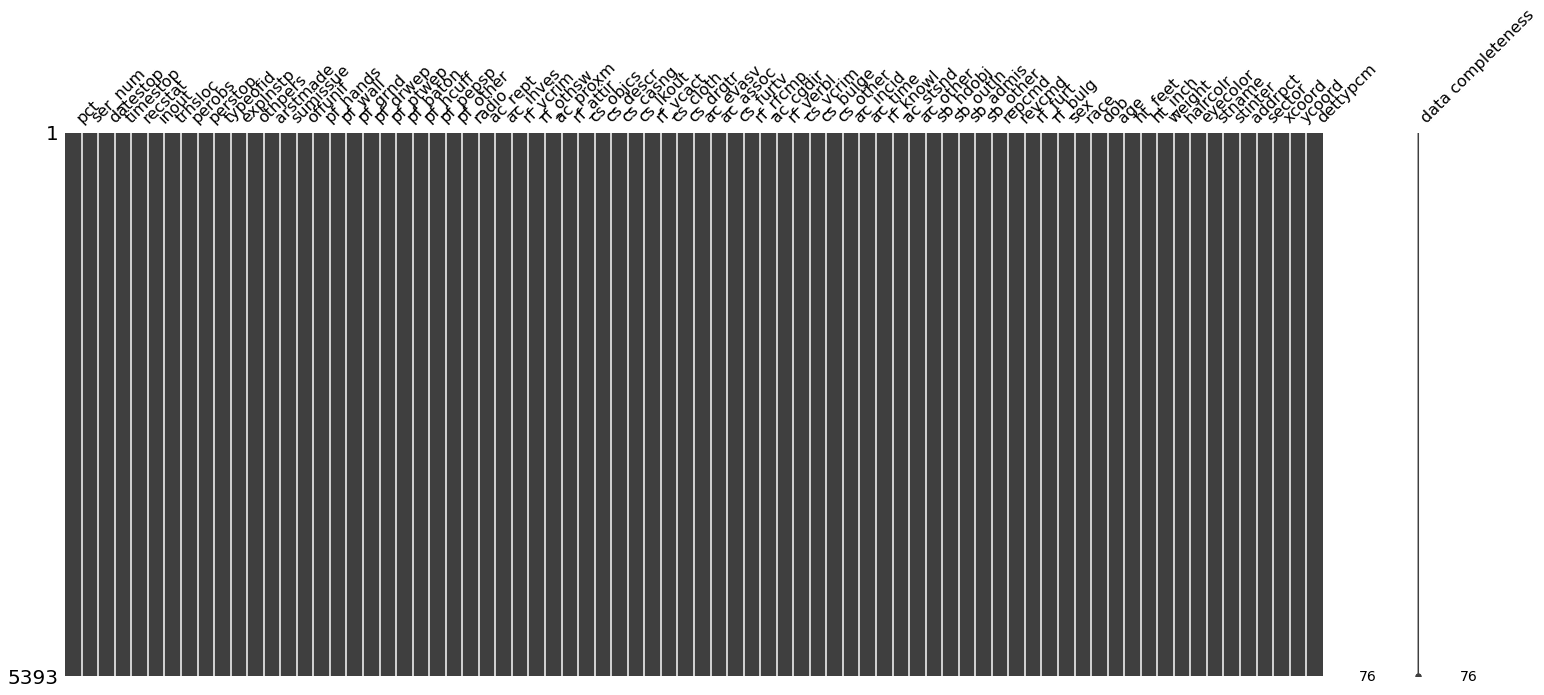

In [15]:
msngo.matrix(df, labels=True)

### Grafico del vector objetivo

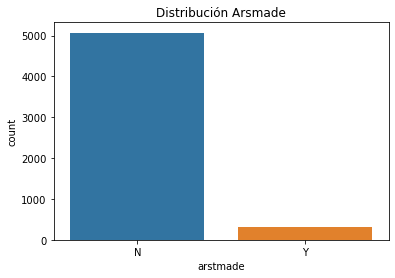

In [16]:
sns.countplot(x='arstmade', data=df)
plt.title('Distribución Arsmade')
plt.show()

Se observa una gran diferencia en la frecuencia entre las clases Yes y No, en donde Yes es la que presenta una menor cantidad. 

In [17]:
df.arstmade.value_counts()

N    5070
Y     323
Name: arstmade, dtype: int64

En terminos de porcentaje, el 94% de los datos en el vector arsmade corresponde a No (No se realizaron arrestos) y un 6% corresponde a Yes (Si se realizaron arrestos) luego de la detención. 

## Hito 2: Feature Engineering 

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5393 entries, 0 to 5811
Data columns (total 76 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pct       5393 non-null   float64
 1   ser_num   5393 non-null   float64
 2   datestop  5393 non-null   float64
 3   timestop  5393 non-null   float64
 4   recstat   5393 non-null   object 
 5   inout     5393 non-null   object 
 6   trhsloc   5393 non-null   object 
 7   perobs    5393 non-null   float64
 8   perstop   5393 non-null   float64
 9   typeofid  5393 non-null   object 
 10  explnstp  5393 non-null   object 
 11  othpers   5393 non-null   object 
 12  arstmade  5393 non-null   object 
 13  sumissue  5393 non-null   object 
 14  offunif   5393 non-null   object 
 15  pf_hands  5393 non-null   object 
 16  pf_wall   5393 non-null   object 
 17  pf_grnd   5393 non-null   object 
 18  pf_drwep  5393 non-null   object 
 19  pf_ptwep  5393 non-null   object 
 20  pf_baton  5393 non-null   obje

In [19]:
df['arstmade'] = np.where(df['arstmade']=='Y', 1,0)

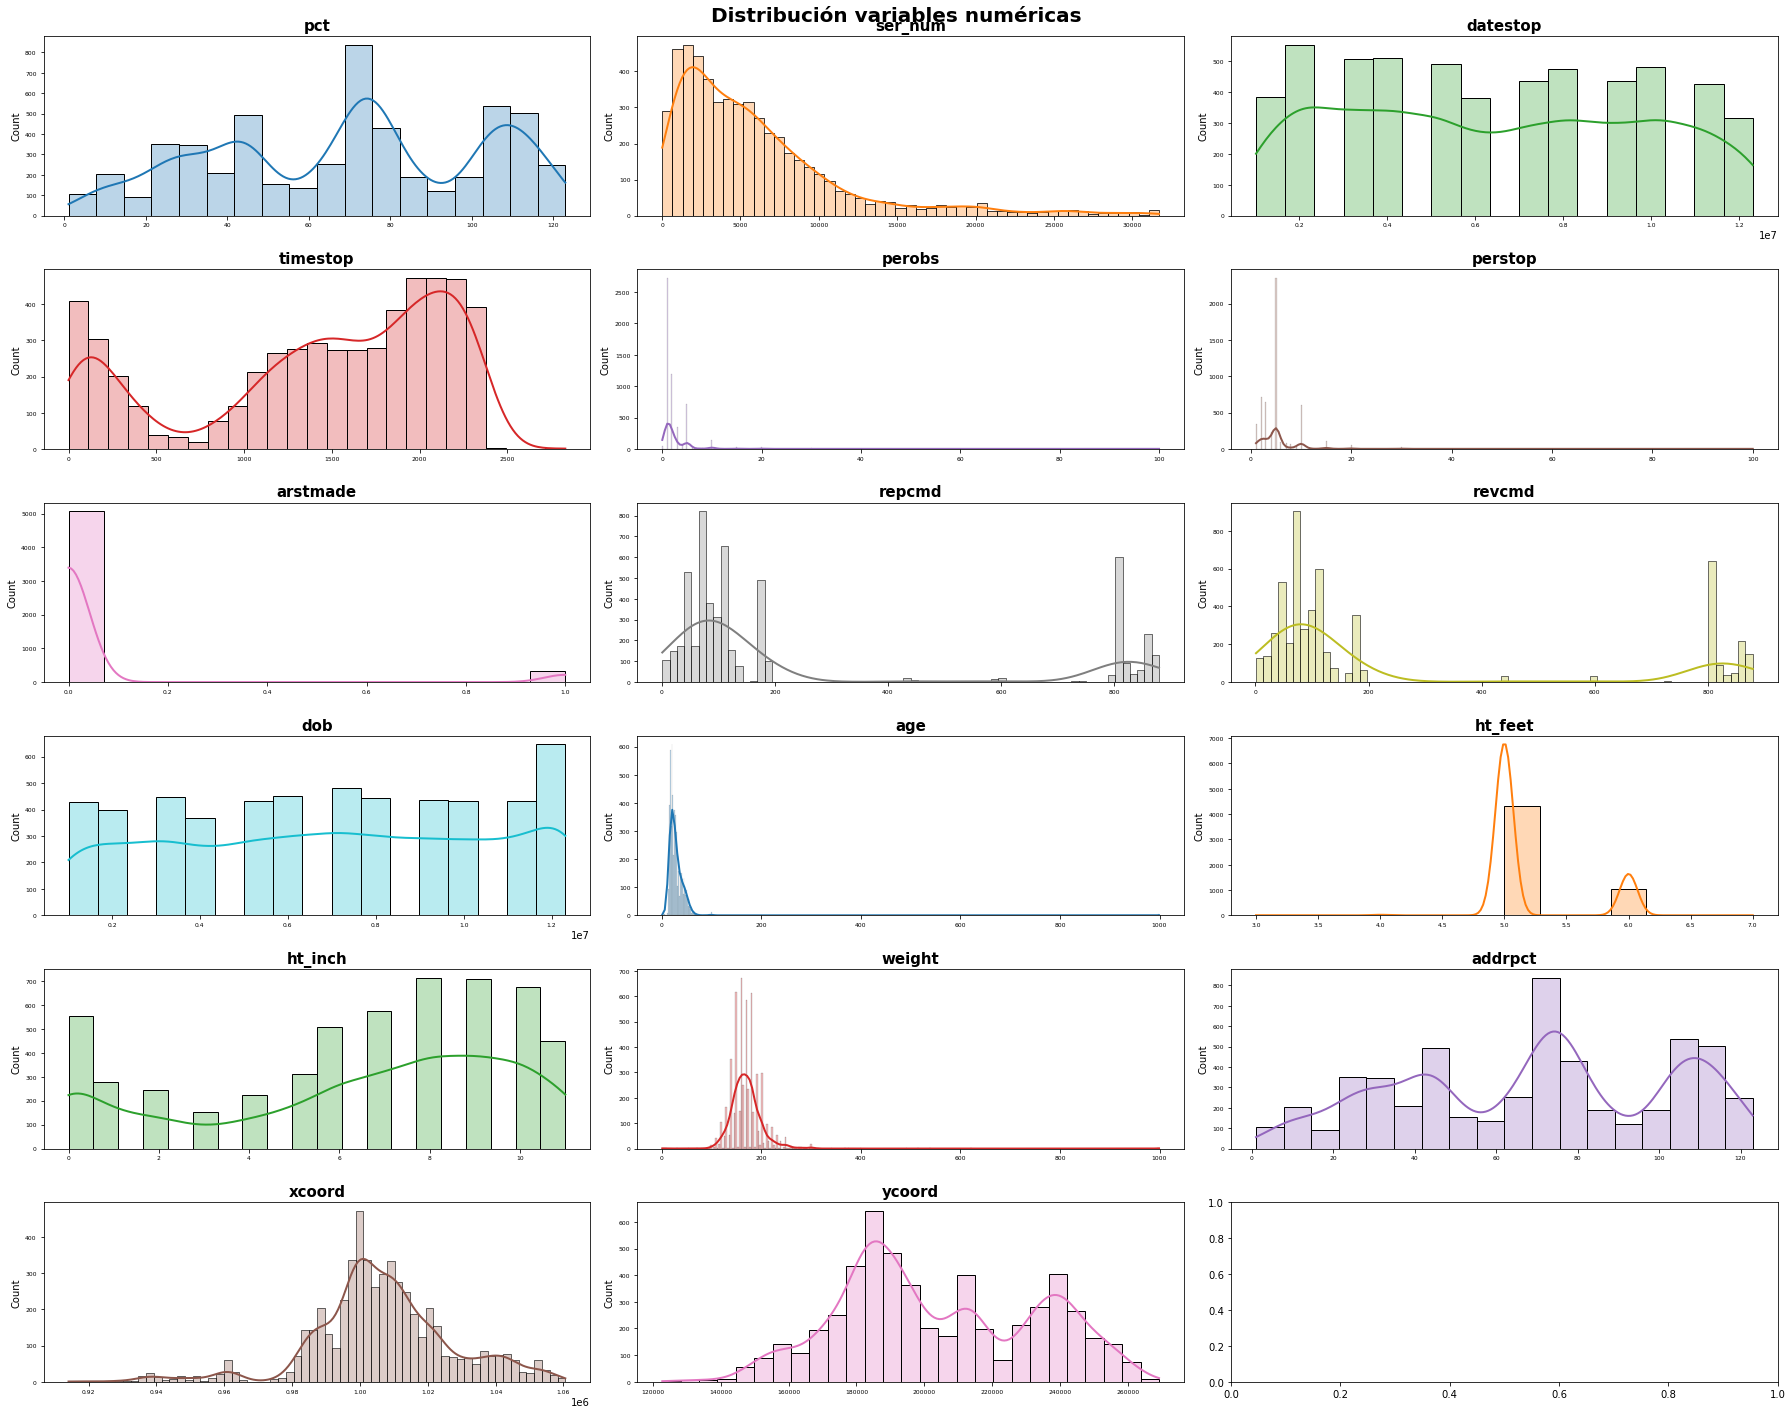

In [20]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(25,20))
axes = axes.flat
columnas_numeric = df.select_dtypes(include=['float64', 'int']).columns

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = df,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    
plt.subplots_adjust(top = 1.5)   
fig.suptitle('Distribución variables numéricas', fontsize = 20, fontweight = "bold");
fig.tight_layout()

#### Regresion Logistica

In [21]:
def binarizacion(df):
    """
    Se ingresa el dataframe en el que se requieren binarizar las variales tipo object y sale el dataframe 
    binarizado.
    """
    for cols in df.select_dtypes(include=['object']).columns:
         df = pd.concat([df, pd.get_dummies(df[cols], prefix=cols, drop_first=True)], axis=1).drop(cols, axis=1)
    return df

#### LabelEncoder

In [22]:
le = LabelEncoder()
df = df.apply(le.fit_transform) 

In [23]:
df

pct  ser_num  datestop  timestop  recstat  inout  trhsloc  perobs  \
0      23      801        92        76        1      1        1       8   
1      65     2494       301       329        1      1        1      10   
2      25     3250       278       502        0      1        1       8   
3      48      365        22       680        1      1        1      12   
4      67     3739       346       600        1      1        1      10   
...   ...      ...       ...       ...      ...    ...      ...     ...   
5807   33     1674        86       106        1      1        1       8   
5808   50     4026       271       757        1      1        1      10   
5809   41     1401       176       728        0      1        1       8   
5810   47      548        68        51        0      1        0       8   
5811    5      402       133        34        0      1        0      12   

      perstop  typeofid  ...  weight  haircolr  eyecolor  stname  stinter  \
0           1         1  ...      33         1         2     534     1446   
1           4         1  ...      31         1         2     907      215   
2           0         3  ...      94         3         2     907     1339   
3           4         1  ...      18         1         2     709      929   
4           9         1  ...      52         1         2     907      193   
...       ...       ...  ...     ...       ...       ...     ...      ...   
5807        0         3  ...      38         1         2     907      835   
5808        1         1  ...      64         1         2     907     1317   
5809        1         1  ...      38         1         2     907      747   
5810        4         1  ...      47         1         2     237      513   
5811       14         1  ...      87         1         2     859        1   

      addrpct  sector  xcoord  ycoord  dettypcm  
0          23       6    2774    3522         0  
1          65       9    2700    2699         0  
2          25       4    3082    3610         0  
3          48       9    1782    1158         0  
4          67       7    3479    2560         0  
...       ...     ...     ...     ...       ...  
5807       33       0    2475    4140         0  
5808       50       5    1657    1896         0  
5809       41       1    2751     654         0  
5810       47       0     262    1327         0  
5811        5       3     346    2692         0  

[5393 rows x 76 columns]

In [24]:
X_train = df.drop('arstmade', axis=1)

In [25]:
y_train = df['arstmade']

#### Se realizará la limpieza de los datos de igual manera que se hizo anteriormente.

In [26]:
df_test = pd.read_csv('2010_1perc.csv').drop('Unnamed: 0', axis=1)

In [27]:
df_test

year  pct  ser_num  datestop  timestop recstat inout trhsloc  perobs  \
0     2010    6      487   1192010      1420       1     O       P       2   
1     2010   42     7138   9042010       225       1     I       T      10   
2     2010   33     2628   6302010      1240       1     I       T       5   
3     2010  108     6384  11172010      2338       1     O       P       3   
4     2010   14     2295   3072010      2240       1     I       T       5   
...    ...  ...      ...       ...       ...     ...   ...     ...     ...   
6008  2010   60     7062   9262010        45       1     O       H       2   
6009  2010   75    15797   7302010        10       A     O       P       1   
6010  2010  123      830   4302010      1630       A     O       P       3   
6011  2010  115    13122  11232010      2100       1     O       P       1   
6012  2010   14      219   1062010      1406       1     I       T       4   

       crimsusp  ...  zip addrpct sector beat post   xcoord  ycoord dettypcm  \
0           FEL  ...            6      G        38   983543  208767       CM   
1        FELONY  ...           42      E            1014172  241737       CM   
2       ROBBERY  ...           33      B    6       1000916  245710       CM   
3          CSCS  ...          108      J            1012612  212240       CM   
4     MISD/ CPW  ...           14      C    7        987636  212439       CM   
...         ...  ...  ...     ...    ...  ...  ...      ...     ...      ...   
6008       MISD  ...           60      I             989382  155162       CM   
6009    ROBBERY  ...           75      A            1012757  186018       CM   
6010        GLA  ...          123      E             933868  138600       CM   
6011     FELONY  ...          115      E            1014722  214388       CM   
6012  CRIM MIS.  ...           14      H   11        987078  215157       CM   

      linecm  detailcm  
0          1        85  
1          1        45  
2          1        85  
3          1        28  
4          1        20  
...      ...       ...  
6008       1        20  
6009       1        85  
6010       1        46  
6011       1        85  
6012       1        23  

[6013 rows x 111 columns]

In [28]:
df_test = ver_datos_perdidos(df_test)

In [29]:
df_test=df_test.drop(['zip','state','city', 'crossst', 'premname','aptnum', 'rescode', 'build', 'premtype', 'othfeatr',
           'officrid', 'sumoffen','post','beat', 'comppct','offverb', 'offshld','addrnum', 'detailcm','frisked', 'searched', 'contrabn', 'adtlrept',
           'pistol', 'riflshot', 'asltweap', 'knifcuti', 'machgun', 'othrweap', 'offshld','arstoffn','compyear',
           'contrabn', 'year', 'linecm', 'addrtyp', 'crimsusp'], axis=1)

df_test['stname'] = np.where(df_test['stname'].isna(), 'no registration', df_test['stname'])
df_test['xcoord'] = df_test['xcoord'].astype('float64')
df_test['ycoord'] = df_test['ycoord'].astype('float64')
df_test['addrpct'] = df_test['addrpct'].astype('float64')

In [30]:
df_test = df_test.dropna()

<AxesSubplot:>

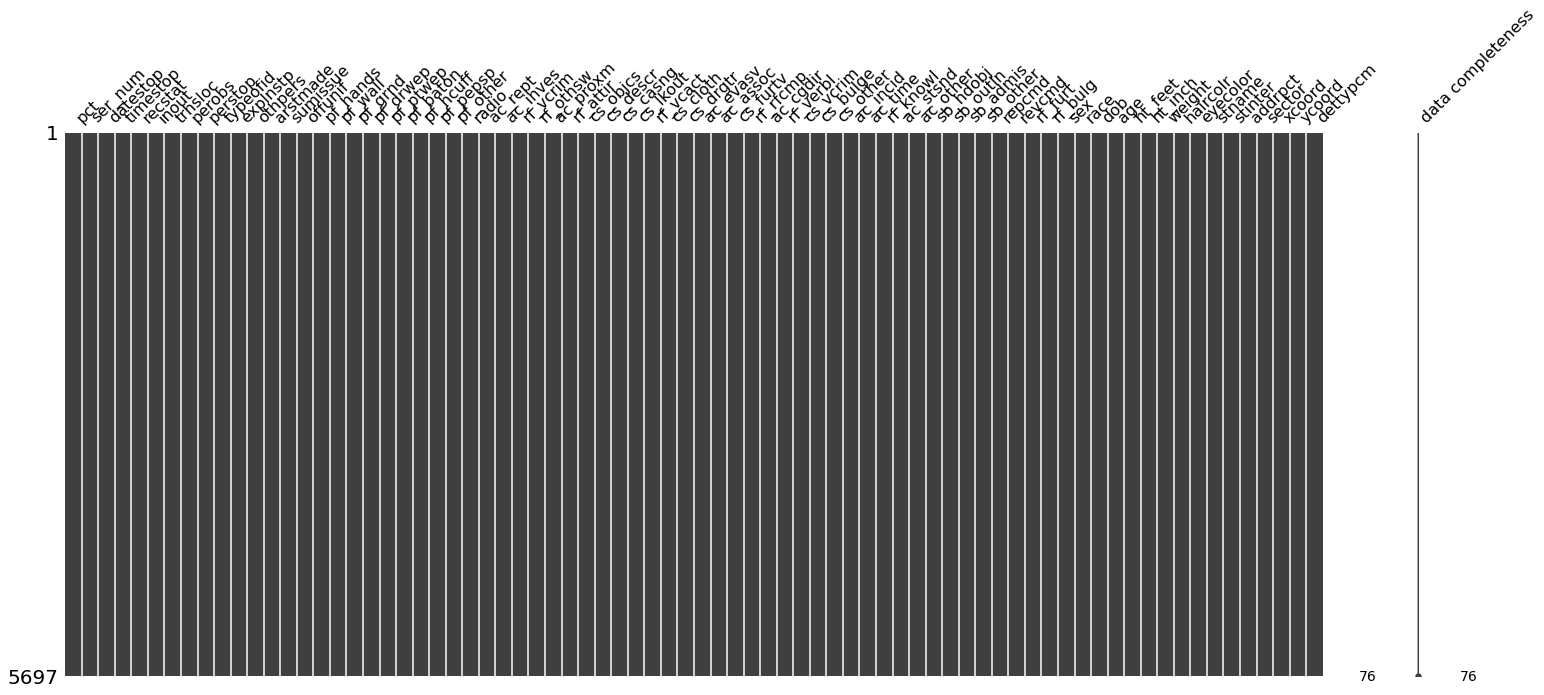

In [31]:
msngo.matrix(df_test, labels=True)

#### LabelEncoder

In [32]:
df_test

pct  ser_num    datestop  timestop recstat inout trhsloc  perobs  \
0       6.0    487.0   1192010.0    1420.0       1     O       P     2.0   
1      42.0   7138.0   9042010.0     225.0       1     I       T    10.0   
2      33.0   2628.0   6302010.0    1240.0       1     I       T     5.0   
3     108.0   6384.0  11172010.0    2338.0       1     O       P     3.0   
4      14.0   2295.0   3072010.0    2240.0       1     I       T     5.0   
...     ...      ...         ...       ...     ...   ...     ...     ...   
6008   60.0   7062.0   9262010.0      45.0       1     O       H     2.0   
6009   75.0  15797.0   7302010.0      10.0       A     O       P     1.0   
6010  123.0    830.0   4302010.0    1630.0       A     O       P     3.0   
6011  115.0  13122.0  11232010.0    2100.0       1     O       P     1.0   
6012   14.0    219.0   1062010.0    1406.0       1     I       T     4.0   

      perstop typeofid  ... weight haircolr eyecolor           stname  \
0         5.0        P  ...  175.0       BR       GR         8 AVENUE   
1         2.0        V  ...  175.0       BK       BR  no registration   
2         4.0        V  ...  200.0       BK       BR  no registration   
3         5.0        V  ...  210.0       BK       BR        65 STREET   
4         7.0        P  ...  170.0       ZZ       BR  no registration   
...       ...      ...  ...    ...      ...      ...              ...   
6008      2.0        P  ...  150.0       BK       BR    WEST 11 STREE   
6009      1.0        R  ...  180.0       BK       BR  no registration   
6010      5.0        P  ...  200.0       GY        Z  no registration   
6011      5.0        P  ...  185.0       BK       BR  no registration   
6012      2.0        P  ...  185.0       BK       BR  no registration   

                  stinter addrpct sector     xcoord    ycoord dettypcm  
0          WEST 14 STREET     6.0      G   983543.0  208767.0       CM  
1      SOUTHERN BOULEVARD    42.0      E  1014172.0  241737.0       CM  
2                BROADWAY    33.0      B  1000916.0  245710.0       CM  
3               37 AVENUE   108.0      J  1012612.0  212240.0       CM  
4          WEST 34 STREET    14.0      C   987636.0  212439.0       CM  
...                   ...     ...    ...        ...       ...      ...  
6008             AVENUE X    60.0      I   989382.0  155162.0       CM  
6009  PENNSYLVANIA AVENUE    75.0      A  1012757.0  186018.0       CM  
6010         ARDEN AVENUE   123.0      E   933868.0  138600.0       CM  
6011   NORTHERN BOULEVARD   115.0      E  1014722.0  214388.0       CM  
6012             8 AVENUE    14.0      H   987078.0  215157.0       CM  

[5697 rows x 76 columns]

In [33]:
df_test['arstmade'] = np.where(df_test['arstmade']=='Y', 1,0)

In [34]:
df_test = df_test.apply(le.fit_transform)

In [35]:
df_test

pct  ser_num  datestop  timestop  recstat  inout  trhsloc  perobs  \
0       2      249        18       516        0      1        1       2   
1      24     3040       246       124        0      0        2      10   
2      20     1305       180       441        0      0        2       5   
3      65     2777       320       986        0      1        1       3   
4       7     1138        65       936        0      0        2       5   
...   ...      ...       ...       ...      ...    ...      ...     ...   
6008   34     3009       268        39        0      1        0       2   
6009   46     4375       210         8        1      1        1       1   
6010   75      423       119       619        1      1        1       3   
6011   72     4227       326       849        0      1        1       1   
6012    7      113         5       505        0      0        2       4   

      perstop  typeofid  ...  weight  haircolr  eyecolor  stname  stinter  \
0           4         1  ...      63         3         4     104     1448   
1           1         3  ...      63         1         2     982     1303   
2           3         3  ...      82         1         2     982      438   
3           4         3  ...      86         1         2      89      163   
4           6         1  ...      59         9         2     982     1501   
...       ...       ...  ...     ...       ...       ...     ...      ...   
6008        1         1  ...      41         1         2     868      342   
6009        0         2  ...      66         1         2     982     1141   
6010        4         1  ...      82         5        10     982      306   
6011        4         1  ...      70         1         2     982     1099   
6012        1         1  ...      70         1         2     982      242   

      addrpct  sector  xcoord  ycoord  dettypcm  
0           2       6     355    2653         0  
1          24       4    3098    3956         0  
2          20       1    1691    4146         0  
3          65       9    2953    2843         0  
4           7       2     566    2856         0  
...       ...     ...     ...     ...       ...  
6008       34       8     680     150         0  
6009       46       0    2967    1421         0  
6010       75       4      15      19         0  
6011       72       4    3152    2946         0  
6012        7       7     536    2996         0  

[5697 rows x 76 columns]

In [36]:
X_test = df_test.drop('arstmade', axis=1)
y_test = df_test['arstmade']

In [37]:
X_train_std = StandardScaler().fit_transform(X_train)
X_test_std = StandardScaler().fit_transform(X_test)

In [38]:
logistic_regresion = LogisticRegression().fit(X_train_std, y_train)

In [39]:
yhat_logistic_regresion = logistic_regresion.predict(X_test_std)

In [40]:
print(classification_report(y_test, yhat_logistic_regresion))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5320
           1       0.79      0.50      0.62       377

    accuracy                           0.96      5697
   macro avg       0.88      0.75      0.80      5697
weighted avg       0.95      0.96      0.95      5697



Se observa un buen desempeño comparado con el benchmark, pese al gran desequilibrio entre las clases.

#### Arbol de Clasificación

In [49]:
tree_para = {'max_depth':[50,100,200,250], 'max_features' : [None, 'log2', 'sqrt']}
tree_model_grid = GridSearchCV(DecisionTreeRegressor(), tree_para, cv=5, n_jobs=-1).fit(X_train, y_train)

In [50]:
tree_model_grid.best_params_

{'max_depth': 250, 'max_features': None}

In [51]:
y_hat_tree_model = tree_model_grid.best_estimator_.predict(X_test) 

In [52]:
print(classification_report(y_test, y_hat_tree_model))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      5320
           1       0.27      0.49      0.35       377

    accuracy                           0.88      5697
   macro avg       0.62      0.70      0.64      5697
weighted avg       0.92      0.88      0.89      5697



Se empeora el desempeño obtenido con la regresion Logistica. Se observa en la clase 1 un valor de recall mayor a la precicion, lo que se puede deber a que se esta entrenando sobre datos desvalanceados. El algoritmo predice una sola clase, por lo tanto es capaz de encontrar los elementos de la clase pero acierta.

#### AdaBoostClassifier

In [53]:
params_ada={'learning_rate': [0.01, 0.1, 0.5], 'n_estimators': [50,100, 500, 1000, 2000]}
ada_grid_cv = GridSearchCV(AdaBoostClassifier(), params_ada, n_jobs = -1).fit(X_train, y_train)

In [54]:
ada_grid_cv.best_params_

{'learning_rate': 0.01, 'n_estimators': 50}

In [55]:
y_hat_adaboost =ada_grid_cv.best_estimator_.predict(X_test)

In [56]:
print(classification_report(y_test, y_hat_adaboost))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5320
           1       0.80      0.46      0.59       377

    accuracy                           0.96      5697
   macro avg       0.88      0.73      0.78      5697
weighted avg       0.95      0.96      0.95      5697



Se mejora la precision de la clase 1 en este modelo, obteniendo un 80% de precision y un 46% de recall. Esto quiere decir, que el modelo logro identificar ciertos ejemplos dentro de la correspondiente clase, y que tenian caracteristicas bien marcadas de la clase, sin embargo no fue capaz de identificar todas la caracteristicas de la clase.

#### GradientBoostingClassifier

In [57]:
param_gradient = {'learning_rate': [0.01, 0.1, 0.5],'n_estimators': [50, 100, 500, 1000, 2000], 
                   'subsample': [0.1,0.5,0.9]}
gradient_grid_cv = GridSearchCV(GradientBoostingClassifier(), param_gradient, n_jobs=-1, 
                                cv=5).fit(X_train, y_train)

In [58]:
gradient_grid_cv.best_params_

{'learning_rate': 0.01, 'n_estimators': 500, 'subsample': 0.5}

In [60]:
y_hat_gradient_boost=gradient_grid_cv.best_estimator_.predict(X_test)

In [61]:
print(classification_report(y_test, y_hat_gradient_boost))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      5320
           1       0.64      0.56      0.60       377

    accuracy                           0.95      5697
   macro avg       0.81      0.77      0.79      5697
weighted avg       0.95      0.95      0.95      5697



Se obtiene el mejor valor de recall entre todos los modelos realizados y se acerca mucho al benchmark.
Para poder obtener mejores valores se tendra que aumentar artificialmente la cantidad de datos de la clase 1 haciendo overfitting y disminuyendo la cantidad de datos de la clase 0 con underfitting y probar los modelos nuevamente.